## Policy gradient

In value-based methods (Q learning and SARSA) we learn a function that approximates the action-value function and the agent will pick the action that maximizes it. However, the method will not work when our action space is continuous (we will have infinite number of action-value pair) and as such we will need policy-based methods.


## Rough derivation
Instead of learning the Q function, we directly learn the policy

$$
\pi_\theta(a | s) = P(a|s;\theta)
$$

Here $P(a|s;\theta)$ can either be discrete or continuous.

Therefore, we wnat to optimize the parameters of the policy $\pi_\theta(a | s)$ so that it maximizes the expected return

$$
J(\theta) = \mathbb{E}_{\tau\sim\pi_\theta}[R(\tau)]
$$

where

$\tau = (s_0, a_0, r_0, s_1, a_1, r_1, ...)$ is the trajectory following policy $\pi_\theta$ and $R(\tau) = \sum_{t=0}^T \gamma^ r_t$ is the total discounted return. Taking an expectation of $R(\tau)$ over the distribution of all the trajectories means: if we repeatedly run the environment using the current policy, what is the average discounted sum of rewards we’ll get? and we want to maximize that. Since the probability of a trajectory is:

$$
P_{\theta}(\tau) = \rho(s_0) \prod_{t=0}^{T} \pi_{\theta}(a_t \mid s_t) P(s_{t+1} \mid s_t, a_t)
$$

therefore, $J(\theta) = \sum_\tau P_\theta(\tau)R(\tau)$. And the gradient of this objective function is

$$
\begin{align*}
\nabla_{\theta} J(\theta) &= \sum_{\tau} \nabla_{\theta} P_{\theta}(\tau) R(\tau) \\
&= \sum_{\tau} P_{\theta}(\tau) \nabla_{\theta} \log P_{\theta}(\tau) R(\tau) \quad \text{(log-derivative)} \\
&= \mathbb{E}_{ \tau \sim \pi_{\theta}} \left[ \nabla_{\theta} \log P_{\theta}(\tau) R(\tau) \right] \\
&= \mathbb{E}_{\tau \sim \pi_{\theta}} \left[ \left( \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) \right) R(\tau) \right]
\end{align*}
$$

The last line follows since the only term in $P_\theta(\tau)$ that depends on $\theta$ is $\pi_\theta(a_t|s_t)$. Lastly, instead of weighting each action over the total return $R(\tau)$, it may be better to weight by the return from that time step onwards, meaning

$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}} \left[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t \right]
$$

where $G_t = \sum_{k=t}^T \gamma^{k-t}r_k$.

## REINFORCE algorithm
Since we cant really compute the exact expectation since there are infinitely many trajectories, we use the Monte Carlo method to sample some episodes and estimate

$$
\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t^{(i)} \mid s_t^{(i)}) R(\tau^{(i)}) \right]
$$

## Actor Critic
Note that $G_t$ can be **very** noisy, depending on the environment and initialization, weighting the action by $G_t$ may lead to high variance in the training.

Therefore, we can try to reduce the variance by replacing $G_t$ with a learned baseline $V(t)$, meaning the update will only be positive (and big) if the action is doing better than the current expected return.

## Advantage Actor Critic (A2C)
This algorithim refines Actor Critic by using the advantage function

$$
A(s_t, a_t) = Q(s_t, a_t) - V(s_t) \approx r_t + \gamma V(S_{t+1}) - V(S_t)
$$

where the last approximation is what we are familiar in Q learning (1-step TD error)

and the gradient will be

$$
\nabla_{\theta} J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t^{(i)} \mid s_t^{(i)}) A_t{(i)} \right]
$$

Note that we will have to maintain two networks:
1. Policy network (actor) - output $\pi_\theta(a|s_t)$
2. Value netowrk (critic) - similar to Q learning, used to estimate Q functions - output $V(S_t)$

### Rough pseudocode:
1. Select action
2. Execute action, get reward, get next state
3. Compute TD-error (advantage estimate)
4. Update actor
5. Update critic
6. Repeat

## Trust Region Policy Optimization (TRPO)
Once again, even the advantage function may still be noisy, and if $A_t$ is too big, the policy can change drastically, leading to poor performance and training.

So the idea is we make sure to update our policy to a "trust region" that is "safe", by making sure the new policy is not too far from the old one, measured by KL divergence. Hence, the problem becomes the following optimization problem:

$$
L^{\text{TRPO}}(\theta) = \mathbb{E}_t \left[ \frac{\pi_{\theta}(a_t \mid s_t)}{\pi_{\theta_{\text{old}}}(a_t \mid s_t)} \hat{A}_t \right]$$

subject to a trust region constraint:
$$ \mathbb{E}_t \left[ \text{KL}\left( \pi_{\theta_{\text{old}}}(\cdot \mid s_t) \parallel \pi_{\theta}(\cdot \mid s_t) \right) \right] \leq \delta
$$

The ratio $\frac{\pi_\theta}{\pi_{old}}$ measures how much more likely the new policy makes an action compared to the old one

However, it means we have to solve a constrained optimization problem which can be heavy to implement

## Proximal Policy Optimization (PPO)
PPO was designed to achieve the same goal as TRPO but without having to solve a constrained optimization problem. Instead of a hard KL constraint, PPO uses a surrogate clipped objective

$$
L^{\text{PPO}}(\theta) = \mathbb{E}_t \left[ \min\left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]
$$

where $r_t = \frac{\pi_\theta}{\pi_{old}}$ and $\epsilon$ is a small hyperparameter

The idea is that if $r_t \approx 1$ -> update normally, but if it deviates too much ( $> 1+\epsilon$ or $< 1-\epsilon$), we clip it to prevent any single update from being too aggressive.

**Case 1: if $A_t > 0$**

We want to encourage the action (but not too much), so $\min\left(r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\right) = (1+\epsilon)\hat{A}_t$

**Case 2: if $A_t < 0$**

We want to discourage the action (again but not too much), so $\min\left(r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\right) = (1-\epsilon)\hat{A}_t$ which is less negative than the unclipped one

So the PPO essentially "trusts" the old policy and allows only "proximal" improvement.

## Choice of advantage function

While we can use the advantage function as in A2C (1 step TD error), it has high bias since we are only looking 1 step ahead. If we wait till the end of the episode (Monte Carlo approach), it is unbiased but may have high variance. A balance of this is to use Generalized Advantage Estimate (GAE) that provides a tradeoff between the two which makes the advantage function estimate more stable and smoother:

$$
\hat{A}_t= \sum_{l=0}^{\infty}(\gamma \lambda)^l \delta_{t+l}
$$

where $\delta_t = r_t + \gamma V(S_{t+1}) - V(S_t)$

Essentially it is a exponentially weighted sum of multi-step TD errors. Note that if $\lambda = 1$, we recover the monte carlo estimate, and if $\lambda = 0$, we recover the 1-step TD error.



## Entropy regularization
One issue with PPO (or any other policy gradient method) is premature convergence: the policy may collapse too quickly into always picking one action, even before it has fully explored the environment.

To prevent this, we can add entropy to the objective function to encourage exploration (similar to epsilon greedy algorithm in Q learning). The modified loss is thus

$$
L^{\text{PPO-entropy}}(\theta) = L^{\text{PPO}}(\theta) + \beta \mathbb{E}_t \left[ \mathcal{H}(\pi_\theta(\cdot \mid s_t)) \right]
$$

where $\mathcal{H}$ is the entropy of the policy distribution (high when the policy is uncertain, low when it’s very deterministic), and $\beta$ is a hyperparameter controlling the strength of exploration.

This is exceptionally powerful at early stage where $L^{PPO}$ is small and the entropy term will dominate, encouraging explorations, and will slowly diminish once $L^{PPO}$ becomes more dominant and the policy becomes more deterministic (exploitation)


## A note on parallelization
We also note that for policy gradient method, having multiple parallel run helps a lot, since each run is just a datapoint. This makes it very similar to supervised learning.

Suppose we have 2000 envs, each step gives us 2000 "datapoints". We can use the idea of mini batch SGD to update our parameter for a few epochs (each epoch consists of the 2000 datapoints), before discarding them and move on to the next step.

This makes policy gradient method to be very beneficial from parallel computing, since each experinece is fully utilized, whereas in value based method, we have to set up a replay buffer, and the experience in the buffer may or may not be used.

In [2]:
!pip install gymnax

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import gymnax
from gymnax.environments import environment
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any
import time

## A2C Implementation

Update 0: ActorLoss=0.591, CriticLoss=1.695, Episodes Collected=113, MeanLast100=16.94
Update 10: ActorLoss=0.252, CriticLoss=9.312, Episodes Collected=2098, MeanLast100=9.49
Update 20: ActorLoss=0.081, CriticLoss=0.180, Episodes Collected=4257, MeanLast100=9.52
Update 30: ActorLoss=-0.430, CriticLoss=0.604, Episodes Collected=6099, MeanLast100=11.63
Update 40: ActorLoss=0.060, CriticLoss=0.597, Episodes Collected=6546, MeanLast100=61.78
Update 50: ActorLoss=-0.134, CriticLoss=0.923, Episodes Collected=6700, MeanLast100=150.19
Update 60: ActorLoss=-0.988, CriticLoss=5.365, Episodes Collected=7676, MeanLast100=38.97
Update 70: ActorLoss=-0.253, CriticLoss=1.332, Episodes Collected=8167, MeanLast100=40.11
Update 80: ActorLoss=1.474, CriticLoss=1.571, Episodes Collected=8534, MeanLast100=80.53
Update 90: ActorLoss=0.017, CriticLoss=1.306, Episodes Collected=8662, MeanLast100=166.11


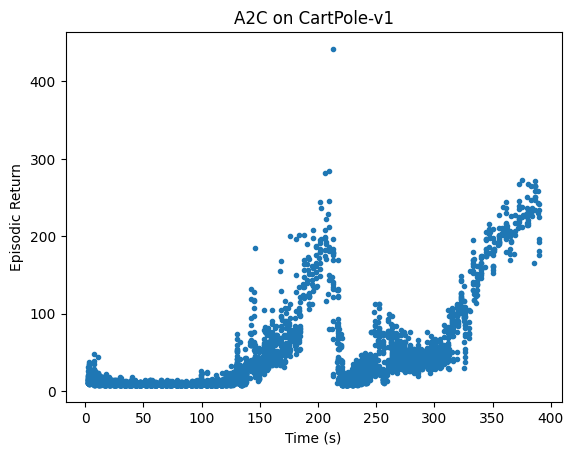

In [ ]:
# ---------------------------
# Actor & Critic Networks
# ---------------------------
class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        return nn.Dense(self.action_dim)(x)  # logits

class Critic(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        return nn.Dense(1)(x).squeeze(-1)  # scalar value

# ---------------------------
# Init models & optimizers
# ---------------------------
def init_models_and_opts(rng, obs_shape, action_dim, lr=5e-5):
    rng, a_key, c_key = jax.random.split(rng, 3)
    dummy_obs = jnp.zeros(obs_shape)

    actor = Actor(action_dim)
    critic = Critic()

    params_actor = actor.init(a_key, dummy_obs)
    params_critic = critic.init(c_key, dummy_obs)

    opt_actor = optax.adam(lr)
    opt_critic = optax.adam(lr)

    opt_state_actor = opt_actor.init(params_actor)
    opt_state_critic = opt_critic.init(params_critic)

    return actor, critic, params_actor, params_critic, opt_actor, opt_critic, opt_state_actor, opt_state_critic

# ---------------------------
# Action selection
# ---------------------------
def select_action(params_actor, obs, rng, actor):
    logits = actor.apply(params_actor, obs)
    probs = jax.nn.softmax(logits)
    rng, subkey = jax.random.split(rng)
    action = jax.random.categorical(subkey, logits)
    return action, probs[action], rng

# ---------------------------
# Vectorized environment step
# ---------------------------
def vectorized_step(rng, env_states, actions, env, env_params):
    rng, step_key = jax.random.split(rng)

    # Get the number of environments from the actions array
    num_envs = actions.shape[0]
    step_keys = jax.random.split(step_key, num_envs)

    next_obs, next_env_states, rews, dones, infos = jax.vmap(
        env.step, in_axes=(0, 0, 0, None)
    )(step_keys, env_states, actions, env_params)
    return next_obs, next_env_states, rews, dones, infos, rng

# ---------------------------
# Training loop
# ---------------------------
import time
import jax.profiler

def train_a2c_gpu_episodic(rng, num_envs=16, batch_size=128, num_epochs=3, mini_batch_size=32, num_updates=100):
    env, env_params = gymnax.make("CartPole-v1")
    obs_shape = env.observation_space(env_params).shape
    action_dim = env.action_space(env_params).n

    actor, critic, params_actor, params_critic, opt_actor, opt_critic, opt_state_actor, opt_state_critic = \
        init_models_and_opts(rng, obs_shape, action_dim)

    # Reset vectorized envs
    rng, reset_key = jax.random.split(rng)
    reset_keys = jax.random.split(reset_key, num_envs)
    obs, env_states = jax.vmap(env.reset, in_axes=(0, None))(reset_keys, env_params)

    gamma = 0.99

    # -------------------
    # JITed action selection
    # -------------------
    @jax.jit
    def select_actions(params_actor, obs, rng):
        logits = jax.vmap(actor.apply, in_axes=(None, 0))(params_actor, obs)
        rng, subkey = jax.random.split(rng)
        actions = jax.vmap(lambda k, l: jax.random.categorical(k, l))(jax.random.split(subkey, obs.shape[0]), logits)
        return actions, rng

    # -------------------
    # JITed update
    # -------------------
    @jax.jit
    def update(params_actor, params_critic, opt_state_actor, opt_state_critic,
               obs, acts, rews, next_obs, dones, gamma=0.99):
        values = critic.apply(params_critic, obs)
        next_values = critic.apply(params_critic, next_obs)
        targets = rews + gamma * (1 - dones) * next_values
        adv = targets - values

        # Actor
        def loss_actor_fn(params):
            logits = actor.apply(params, obs)
            log_probs = jax.nn.log_softmax(logits)
            logp_a = log_probs[jnp.arange(acts.shape[0]), acts]
            return -(logp_a * adv).mean()
        actor_loss, actor_grads = jax.value_and_grad(loss_actor_fn)(params_actor)
        updates_actor, opt_state_actor = opt_actor.update(actor_grads, opt_state_actor)
        params_actor = optax.apply_updates(params_actor, updates_actor)

        # Critic
        def loss_critic_fn(params):
            value = critic.apply(params, obs)
            return ((targets - value) ** 2).mean()
        critic_loss, critic_grads = jax.value_and_grad(loss_critic_fn)(params_critic)
        updates_critic, opt_state_critic = opt_critic.update(critic_grads, opt_state_critic)
        params_critic = optax.apply_updates(params_critic, updates_critic)

        return params_actor, params_critic, opt_state_actor, opt_state_critic, actor_loss, critic_loss

    # -------------------
    # Training loop with episodic returns
    # -------------------
    env_running_reward = jnp.zeros(num_envs)
    episodic_returns = []
    timestamps = []
    start_time = time.time()

    for update_i in range(num_updates):
        batch_obs, batch_acts, batch_rews, batch_next_obs, batch_dones = [], [], [], [], []

        while len(batch_obs) < batch_size:
            rng, action_key = jax.random.split(rng)
            actions, rng = select_actions(params_actor, obs, action_key)

            # Step envs
            next_obs, env_states, rews, dones, infos, rng = vectorized_step(
                rng, env_states, actions, env, env_params
            )

            # Update running rewards for episodic return
            env_running_reward += rews
            for i, done in enumerate(dones):
                if done:
                    episodic_returns.append(env_running_reward[i].item())
                    timestamps.append(time.time() - start_time)
                    env_running_reward = env_running_reward.at[i].set(0.0)

            # Store transitions
            batch_obs.append(obs)
            batch_acts.append(actions)
            batch_rews.append(rews)
            batch_next_obs.append(next_obs)
            batch_dones.append(dones)

            obs = next_obs

        # Stack batch
        batch_obs = jnp.concatenate(batch_obs, axis=0)
        batch_acts = jnp.concatenate(batch_acts, axis=0)
        batch_rews = jnp.concatenate(batch_rews, axis=0)
        batch_next_obs = jnp.concatenate(batch_next_obs, axis=0)
        batch_dones = jnp.concatenate(batch_dones, axis=0)

        # Mini-batch updates
        num_samples = batch_obs.shape[0]
        idxs = jnp.arange(num_samples)
        for epoch in range(num_epochs):
            idxs = jax.random.permutation(rng, idxs)
            for start in range(0, num_samples, mini_batch_size):
                end = start + mini_batch_size
                mb_idx = idxs[start:end]
                params_actor, params_critic, opt_state_actor, opt_state_critic, actor_loss, critic_loss = update(
                    params_actor, params_critic, opt_state_actor, opt_state_critic,
                    batch_obs[mb_idx], batch_acts[mb_idx], batch_rews[mb_idx],
                    batch_next_obs[mb_idx], batch_dones[mb_idx], gamma
                )

        if update_i % 10 == 0:
            # Compute last 100 episodic rewards
            last_100_rewards = jnp.array(episodic_returns[-100:])
            mean_last_100 = jnp.nanmean(last_100_rewards) if len(last_100_rewards) > 0 else 0.0

            print(f"Update {update_i}: ActorLoss={actor_loss:.3f}, CriticLoss={critic_loss:.3f}, "
                  f"Episodes Collected={len(episodic_returns)}, "
                  f"MeanLast100={mean_last_100:.2f}")

    return episodic_returns, timestamps


# ---------------------------
# Run training
# ---------------------------
if __name__ == "__main__":
    rng = jax.random.PRNGKey(42)
    returns, times = train_a2c_gpu_episodic(rng)
    plt.plot(times, returns, '.')
    plt.xlabel("Time (s)")
    plt.ylabel("Episodic Return")
    plt.title("A2C on CartPole-v1")
    plt.show()


We can see that the learning curve seems to be quite noisy, we will next try to implement PPO with entropy and GAE as the advantage function.

## PPO Implementation

In [ ]:
# ---------------------------
# Actor & Critic Networks
# ---------------------------
class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        return nn.Dense(self.action_dim)(x)  # logits

class Critic(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        return nn.Dense(1)(x).squeeze(-1)  # scalar value
# ---------------------------
# Init models & opts (slightly adjusted to return apply fns)
# ---------------------------
def init_models_and_opts(rng, obs_shape, action_dim, lr=3e-4):
    rng, a_key, c_key = jax.random.split(rng, 3)
    dummy_obs = jnp.zeros(obs_shape)

    actor = Actor(action_dim)
    critic = Critic()

    params_actor = actor.init(a_key, dummy_obs)
    params_critic = critic.init(c_key, dummy_obs)

    opt_actor = optax.adam(lr)
    opt_critic = optax.adam(lr)

    opt_state_actor = opt_actor.init(params_actor)
    opt_state_critic = opt_critic.init(params_critic)

    return actor, critic, params_actor, params_critic, opt_actor, opt_critic, opt_state_actor, opt_state_critic

# ---------------------------
# Utilities
# ---------------------------
def categorical_logprob(logits, actions):
    logp_all = jax.nn.log_softmax(logits)
    return logp_all[jnp.arange(actions.shape[0]), actions]

def policy_entropy(logits):
    p = jax.nn.softmax(logits)
    return -jnp.sum(p * jax.nn.log_softmax(logits), axis=-1)

# GAE
def compute_gae(rewards, values, dones, last_value, gamma=0.99, lambda_=0.95):
    # rewards: [T, N], values: [T, N], dones: [T, N], last_value: [N]
    T, N = rewards.shape
    advantages = jnp.zeros((T, N))
    gae = jnp.zeros(N)
    # iterate reversed
    for t in range(T - 1, -1, -1):
        next_value = jnp.where(t == T - 1, last_value, values[t + 1])
        next_nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_value * next_nonterminal - values[t]
        gae = delta + gamma * lambda_ * next_nonterminal * gae
        advantages = advantages.at[t].set(gae)
    returns = advantages + values
    return advantages, returns

# ---------------------------
# PPO training function
# ---------------------------
def train_ppo(rng,
              num_envs=16,
              T=128,                # rollout length per env
              total_updates=1000,
              ppo_epochs=4,
              minibatch_size=256,
              gamma=0.99,
              lambda_=0.95,
              clip_eps=0.2,
              value_coef=0.5,
              entropy_coef=0.01,
              actor_lr=3e-4,
              critic_lr=3e-4):
    env, env_params = gymnax.make("CartPole-v1")
    obs_shape = env.observation_space(env_params).shape  # e.g. (4,)
    action_dim = env.action_space(env_params).n

    # init nets and opts
    actor, critic, params_actor, params_critic, opt_actor, opt_critic, opt_state_actor, opt_state_critic = \
        init_models_and_opts(rng, obs_shape, action_dim, lr=actor_lr)

    # reset vectorized envs
    rng, reset_key = jax.random.split(rng)
    reset_keys = jax.random.split(reset_key, num_envs)
    obs, env_states = jax.vmap(env.reset, in_axes=(0, None))(reset_keys, env_params)

    # For jitted batched actor/critic application:
    batched_actor_apply = jax.vmap(actor.apply, in_axes=(None, 0))
    batched_critic_apply = jax.vmap(critic.apply, in_axes=(None, 0))

    # jit action selection returning logits, actions, logprobs, rng
    @jax.jit
    def select_actions_and_logp(params_actor, obs_batch, rng):
        logits = batched_actor_apply(params_actor, obs_batch)  # [N, action_dim]
        rng, subkey = jax.random.split(rng)
        keys = jax.random.split(subkey, obs_batch.shape[0])
        actions = jax.vmap(lambda k, l: jax.random.categorical(k, l))(keys, logits)
        logp = categorical_logprob(logits, actions)
        ent = policy_entropy(logits)
        return actions, logp, ent, logits, rng

    # JITed vectorized step (you had this; minor change to accept actions shape)
    def vectorized_step(rng, env_states, actions, env, env_params):
        rng, step_key = jax.random.split(rng)
        num_envs_local = actions.shape[0]
        step_keys = jax.random.split(step_key, num_envs_local)
        next_obs, next_env_states, rews, dones, infos = jax.vmap(
            env.step, in_axes=(0, 0, 0, None)
        )(step_keys, env_states, actions, env_params)
        return next_obs, next_env_states, rews, dones, infos, rng

    # PPO update for one minibatch (not jitted here because we will jit the outer)
    def ppo_update(params_actor, params_critic, opt_state_actor, opt_state_critic,
                   obs_mb, acts_mb, old_logp_mb, adv_mb, returns_mb, clip_eps):
        # compute losses and gradients
        def loss_fn_actor(p):
            logits = batched_actor_apply(p, obs_mb)
            logp = categorical_logprob(logits, acts_mb)
            ratio = jnp.exp(logp - old_logp_mb)
            unclipped = ratio * adv_mb
            clipped = jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_mb
            actor_loss = -jnp.mean(jnp.minimum(unclipped, clipped))
            entropy = jnp.mean(policy_entropy(logits))
            return actor_loss - entropy_coef * entropy, (actor_loss, entropy)

        (actor_loss_total, (actor_loss_term, entropy_term)), actor_grads = jax.value_and_grad(loss_fn_actor, has_aux=True)(params_actor)
        updates_actor, opt_state_actor = opt_actor.update(actor_grads, opt_state_actor)
        params_actor = optax.apply_updates(params_actor, updates_actor)

        def loss_fn_critic(p):
            value_pred = batched_critic_apply(p, obs_mb)
            value_loss = jnp.mean((returns_mb - value_pred) ** 2)
            return value_loss, value_loss

        (critic_loss_val, critic_loss_term), critic_grads = jax.value_and_grad(loss_fn_critic, has_aux=True)(params_critic)
        updates_critic, opt_state_critic = opt_critic.update(critic_grads, opt_state_critic)
        params_critic = optax.apply_updates(params_critic, updates_critic)

        total_loss = actor_loss_term + value_coef * critic_loss_term - entropy_coef * entropy_term
        return params_actor, params_critic, opt_state_actor, opt_state_critic, actor_loss_term, critic_loss_term, entropy_term

    # jit the ppo_update to accelerate
    ppo_update = jax.jit(ppo_update)

    # bookkeeping
    episodic_returns = []
    env_running_reward = jnp.zeros(num_envs)
    start_time = time.time()

    for update_i in range(total_updates):
        # buffers: store per-step arrays shaped [T, N, ...]
        obs_buf = []
        actions_buf = []
        logp_buf = []
        rewards_buf = []
        dones_buf = []
        values_buf = []
        logits_buf = []

        # Collect T steps
        for t in range(T):
            # compute values and select actions
            values = batched_critic_apply(params_critic, obs)        # [N]
            actions, logp, ent, logits, rng = select_actions_and_logp(params_actor, obs, rng)
            next_obs, env_states, rews, dones, infos, rng = vectorized_step(rng, env_states, actions, env, env_params)

            # store
            obs_buf.append(obs)
            actions_buf.append(actions)
            logp_buf.append(logp)
            rewards_buf.append(rews)
            dones_buf.append(dones)
            values_buf.append(values)
            logits_buf.append(logits)

            # episodic bookkeeping
            env_running_reward += rews
            # when done, append and reset that env's reward
            for i in range(num_envs):
                if dones[i]:
                    episodic_returns.append(float(env_running_reward[i]))
                    env_running_reward = env_running_reward.at[i].set(0.0)

            obs = next_obs

        # convert to arrays: shapes [T, N, ...]
        obs_arr = jnp.stack(obs_buf)        # [T, N, obs_dim]
        acts_arr = jnp.stack(actions_buf)  # [T, N]
        logp_arr = jnp.stack(logp_buf)     # [T, N]
        rews_arr = jnp.stack(rewards_buf)  # [T, N]
        dones_arr = jnp.stack(dones_buf)   # [T, N]
        vals_arr = jnp.stack(values_buf)   # [T, N]

        # compute last value for bootstrap (value of current obs)
        last_values = batched_critic_apply(params_critic, obs)  # [N]

        # compute advantages and returns (GAE)
        advantages, returns = compute_gae(rews_arr, vals_arr, dones_arr, last_values, gamma=gamma, lambda_=lambda_)
        # flatten first for minibatch training: shape [T*N, ...]
        T_, N = advantages.shape
        batch_size = T_ * N
        obs_flat = obs_arr.reshape((batch_size,) + obs_arr.shape[2:])
        acts_flat = acts_arr.reshape((batch_size,))
        logp_flat = logp_arr.reshape((batch_size,))
        adv_flat = advantages.reshape((batch_size,))
        returns_flat = returns.reshape((batch_size,))

        # normalize advantages
        adv_mean = jnp.mean(adv_flat)
        adv_std = jnp.std(adv_flat) + 1e-8
        adv_flat = (adv_flat - adv_mean) / adv_std

        # multiple PPO epochs with minibatches
        # create permutation keys
        perm_key, rng = jax.random.split(rng)
        perm = jax.random.permutation(perm_key, batch_size)
        for epoch in range(ppo_epochs):
            # shuffle each epoch
            perm_key, rng = jax.random.split(rng)
            perm = jax.random.permutation(perm_key, batch_size)
            for start in range(0, batch_size, minibatch_size):
                end = start + minibatch_size
                mb_idx = perm[start:end]
                mb_obs = obs_flat[mb_idx]
                mb_acts = acts_flat[mb_idx]
                mb_old_logp = logp_flat[mb_idx]
                mb_adv = adv_flat[mb_idx]
                mb_returns = returns_flat[mb_idx]

                params_actor, params_critic, opt_state_actor, opt_state_critic, actor_loss, critic_loss, entropy = ppo_update(
                    params_actor, params_critic, opt_state_actor, opt_state_critic,
                    mb_obs, mb_acts, mb_old_logp, mb_adv, mb_returns, clip_eps
                )

        # logging
        if update_i % 10 == 0:
            last_100 = episodic_returns[-100:]
            mean_last_100 = (sum(last_100) / len(last_100)) if len(last_100) > 0 else 0.0
            print(f"Update {update_i}: Episodes Collected={len(episodic_returns)}, MeanLast100={mean_last_100:.2f}, ActorLoss={actor_loss:.3f}, CriticLoss={critic_loss:.3f}, Entropy={float(entropy):.3f}")

    return episodic_returns

# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    rng = jax.random.PRNGKey(42)
    returns = train_ppo(rng, num_envs=32, T=128, total_updates=200, ppo_epochs=4, minibatch_size=1024)
    # plot as you like


Update 0: Episodes Collected=208, MeanLast100=18.58, ActorLoss=-0.003, CriticLoss=62.951, Entropy=0.693
Update 10: Episodes Collected=1020, MeanLast100=132.06, ActorLoss=0.016, CriticLoss=161.885, Entropy=0.613
Update 20: Episodes Collected=1279, MeanLast100=142.37, ActorLoss=-0.024, CriticLoss=288.260, Entropy=0.590
Update 30: Episodes Collected=1633, MeanLast100=133.31, ActorLoss=-0.026, CriticLoss=187.783, Entropy=0.589
Update 40: Episodes Collected=1826, MeanLast100=214.67, ActorLoss=0.020, CriticLoss=219.613, Entropy=0.572
Update 50: Episodes Collected=1974, MeanLast100=269.62, ActorLoss=-0.056, CriticLoss=154.727, Entropy=0.582
Update 60: Episodes Collected=2128, MeanLast100=251.18, ActorLoss=-0.046, CriticLoss=39.616, Entropy=0.583
Update 70: Episodes Collected=2304, MeanLast100=240.12, ActorLoss=0.063, CriticLoss=53.167, Entropy=0.580
Update 80: Episodes Collected=2421, MeanLast100=362.23, ActorLoss=-0.008, CriticLoss=61.295, Entropy=0.581
Update 90: Episodes Collected=2530, Me

Text(0.5, 1.0, 'Training Curve (PPO)')

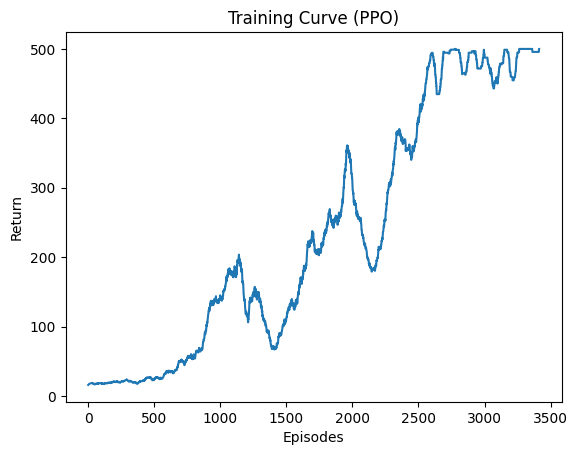

In [ ]:
import numpy as np

def smooth(x, window=50):
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode="valid")

plt.plot(smooth(returns))
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Training Curve (PPO)")


## Improving the code

The above PPO has very good convergence behavior, but the runtime is slightly long, taking around 30 minutes for 200 updates, with each 10 update taking 90-100 seconds. The code below attempts to improve some vectorization process to make it faster (~50 seconds for each 10 steps)

In [19]:
import time
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import gymnax

# ---------------------------
# Actor & Critic Networks
# ---------------------------
class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        return nn.Dense(self.action_dim)(x)  # logits

class Critic(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        return nn.Dense(1)(x).squeeze(-1)  # scalar value

# ---------------------------
# Init models & opts
# ---------------------------
def init_models_and_opts(rng, obs_shape, action_dim, lr=3e-4):
    rng, a_key, c_key = jax.random.split(rng, 3)
    dummy_obs = jnp.zeros(obs_shape)

    actor = Actor(action_dim)
    critic = Critic()

    params_actor = actor.init(a_key, dummy_obs)
    params_critic = critic.init(c_key, dummy_obs)

    opt_actor = optax.adam(lr)
    opt_critic = optax.adam(lr)

    opt_state_actor = opt_actor.init(params_actor)
    opt_state_critic = opt_critic.init(params_critic)

    return actor, critic, params_actor, params_critic, opt_actor, opt_critic, opt_state_actor, opt_state_critic

# ---------------------------
# Utilities
# ---------------------------
def categorical_logprob(logits, actions):
    logp_all = jax.nn.log_softmax(logits)
    return logp_all[jnp.arange(actions.shape[0]), actions]

def policy_entropy(logits):
    p = jax.nn.softmax(logits)
    return -jnp.sum(p * jax.nn.log_softmax(logits), axis=-1)

def compute_gae(rewards, values, dones, last_value, gamma=0.99, lambda_=0.95):
    T, N = rewards.shape
    advantages = jnp.zeros((T, N))
    gae = jnp.zeros(N)
    for t in range(T - 1, -1, -1):
        next_value = jnp.where(t == T - 1, last_value, values[t + 1])
        next_nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_value * next_nonterminal - values[t]
        gae = delta + gamma * lambda_ * next_nonterminal * gae
        advantages = advantages.at[t].set(gae)
    returns = advantages + values
    return advantages, returns

# ---------------------------
# PPO training function
# ---------------------------
def train_ppo(rng,
              num_envs=16,
              T=128,
              total_updates=1000,
              ppo_epochs=4,
              minibatch_size=256,
              gamma=0.99,
              lambda_=0.95,
              clip_eps=0.2,
              value_coef=0.5,
              entropy_coef=0.01,
              actor_lr=3e-4,
              critic_lr=3e-4):

    env, env_params = gymnax.make("CartPole-v1")
    obs_shape = env.observation_space(env_params).shape
    action_dim = env.action_space(env_params).n

    # init nets and opts
    actor, critic, params_actor, params_critic, opt_actor, opt_critic, opt_state_actor, opt_state_critic = \
        init_models_and_opts(rng, obs_shape, action_dim, lr=actor_lr)

    # reset vectorized envs
    rng, reset_key = jax.random.split(rng)
    reset_keys = jax.random.split(reset_key, num_envs)
    obs, env_states = jax.vmap(env.reset, in_axes=(0, None))(reset_keys, env_params)

    # batched actor/critic apply
    batched_actor_apply = jax.jit(jax.vmap(actor.apply, in_axes=(None, 0)))
    batched_critic_apply = jax.jit(jax.vmap(critic.apply, in_axes=(None, 0)))

    # jit action selection
    @jax.jit
    def select_actions_and_logp(params_actor, obs_batch, rng):
        logits = batched_actor_apply(params_actor, obs_batch)
        rng, subkey = jax.random.split(rng)
        keys = jax.random.split(subkey, obs_batch.shape[0])
        actions = jax.vmap(lambda k, l: jax.random.categorical(k, l))(keys, logits)
        logp = categorical_logprob(logits, actions)
        ent = policy_entropy(logits)
        return actions, logp, ent, logits, rng

    # jit env.step
    @jax.jit
    def step_jit(rng, env_state, action):
        next_obs, next_env_state, reward, done, info = env.step(rng, env_state, action, env_params)
        return next_obs, next_env_state, reward, done, info

    vectorized_step = jax.vmap(step_jit, in_axes=(0, 0, 0))

    # PPO minibatch update
    def ppo_update(params_actor, params_critic, opt_state_actor, opt_state_critic,
                   obs_mb, acts_mb, old_logp_mb, adv_mb, returns_mb, clip_eps):

        def loss_fn_actor(p):
            logits = batched_actor_apply(p, obs_mb)
            logp = categorical_logprob(logits, acts_mb)
            ratio = jnp.exp(logp - old_logp_mb)
            unclipped = ratio * adv_mb
            clipped = jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_mb
            actor_loss = -jnp.mean(jnp.minimum(unclipped, clipped))
            entropy = jnp.mean(policy_entropy(logits))
            return actor_loss - entropy_coef * entropy, (actor_loss, entropy)

        (actor_loss_total, (actor_loss_term, entropy_term)), actor_grads = jax.value_and_grad(loss_fn_actor, has_aux=True)(params_actor)
        updates_actor, opt_state_actor = opt_actor.update(actor_grads, opt_state_actor)
        params_actor = optax.apply_updates(params_actor, updates_actor)

        def loss_fn_critic(p):
            value_pred = batched_critic_apply(p, obs_mb)
            value_loss = jnp.mean((returns_mb - value_pred) ** 2)
            return value_loss, value_loss

        (critic_loss_val, critic_loss_term), critic_grads = jax.value_and_grad(loss_fn_critic, has_aux=True)(params_critic)
        updates_critic, opt_state_critic = opt_critic.update(critic_grads, opt_state_critic)
        params_critic = optax.apply_updates(params_critic, updates_critic)

        return params_actor, params_critic, opt_state_actor, opt_state_critic, actor_loss_term, critic_loss_term, entropy_term

    ppo_update = jax.jit(ppo_update)

    episodic_returns = []
    env_running_reward = jnp.zeros(num_envs)
    update_time = []

    for update_i in range(total_updates):
        start_time = time.time()
        obs_buf, actions_buf, logp_buf, rewards_buf, dones_buf, values_buf, logits_buf = [], [], [], [], [], [], []

        for t in range(T):
            values = batched_critic_apply(params_critic, obs)
            actions, logp, ent, logits, rng = select_actions_and_logp(params_actor, obs, rng)

            rng, step_rng = jax.random.split(rng)
            step_keys = jax.random.split(step_rng, num_envs)
            next_obs, env_states, rews, dones, infos = vectorized_step(step_keys, env_states, actions)

            obs_buf.append(obs)
            actions_buf.append(actions)
            logp_buf.append(logp)
            rewards_buf.append(rews)
            dones_buf.append(dones)
            values_buf.append(values)
            logits_buf.append(logits)

            env_running_reward += rews
            for i in range(num_envs):
                if dones[i]:
                    episodic_returns.append(float(env_running_reward[i]))
                    env_running_reward = env_running_reward.at[i].set(0.0)

            obs = next_obs

        # convert to arrays
        obs_arr = jnp.stack(obs_buf)
        acts_arr = jnp.stack(actions_buf)
        logp_arr = jnp.stack(logp_buf)
        rews_arr = jnp.stack(rewards_buf)
        dones_arr = jnp.stack(dones_buf)
        vals_arr = jnp.stack(values_buf)

        last_values = batched_critic_apply(params_critic, obs)
        advantages, returns = compute_gae(rews_arr, vals_arr, dones_arr, last_values, gamma, lambda_)

        # flatten
        T_, N = advantages.shape
        batch_size = T_ * N
        obs_flat = obs_arr.reshape((batch_size,) + obs_arr.shape[2:])
        acts_flat = acts_arr.reshape((batch_size,))
        logp_flat = logp_arr.reshape((batch_size,))
        adv_flat = advantages.reshape((batch_size,))
        returns_flat = returns.reshape((batch_size,))

        adv_flat = (adv_flat - jnp.mean(adv_flat)) / (jnp.std(adv_flat) + 1e-8)

        perm_key, rng = jax.random.split(rng)
        perm = jax.random.permutation(perm_key, batch_size)

        for epoch in range(ppo_epochs):
            perm_key, rng = jax.random.split(rng)
            perm = jax.random.permutation(perm_key, batch_size)
            for start in range(0, batch_size, minibatch_size):
                end = start + minibatch_size
                mb_idx = perm[start:end]
                mb_obs = obs_flat[mb_idx]
                mb_acts = acts_flat[mb_idx]
                mb_old_logp = logp_flat[mb_idx]
                mb_adv = adv_flat[mb_idx]
                mb_returns = returns_flat[mb_idx]

                params_actor, params_critic, opt_state_actor, opt_state_critic, actor_loss, critic_loss, entropy = \
                    ppo_update(params_actor, params_critic, opt_state_actor, opt_state_critic,
                               mb_obs, mb_acts, mb_old_logp, mb_adv, mb_returns, clip_eps)

        update_time.append(time.time() - start_time)

        if update_i % 10 == 0:
            last_100 = episodic_returns[-100:]
            mean_last_100 = (sum(last_100) / len(last_100)) if len(last_100) > 0 else 0.0
            time_to_update_10 = sum(update_time[-10:])
            print(f"Update {update_i}: Episodes={len(episodic_returns)}, MeanLast100={mean_last_100:.2f}, "
                  f"ActorLoss={actor_loss:.3f}, CriticLoss={critic_loss:.3f}, Entropy={float(entropy):.3f}, "
                  f"Time for 10 updates={time_to_update_10:.3f}s")

    return episodic_returns

# ---------------------------
# Run example
# ---------------------------
if __name__ == "__main__":
    rng = jax.random.PRNGKey(42)
    returns = train_ppo(rng, num_envs=32, T=128, total_updates=200, ppo_epochs=4, minibatch_size=1024)


Update 0: Episodes=208, MeanLast100=18.58, ActorLoss=-0.003, CriticLoss=62.951, Entropy=0.693, Time for 10 updates=8.978s
Update 10: Episodes=1020, MeanLast100=132.06, ActorLoss=0.016, CriticLoss=161.885, Entropy=0.613, Time for 10 updates=51.398s
Update 20: Episodes=1238, MeanLast100=213.75, ActorLoss=0.020, CriticLoss=301.694, Entropy=0.580, Time for 10 updates=50.734s
Update 30: Episodes=1492, MeanLast100=127.29, ActorLoss=0.015, CriticLoss=211.030, Entropy=0.603, Time for 10 updates=49.146s
Update 40: Episodes=1672, MeanLast100=258.17, ActorLoss=-0.007, CriticLoss=149.327, Entropy=0.597, Time for 10 updates=48.288s
Update 50: Episodes=1852, MeanLast100=235.64, ActorLoss=-0.032, CriticLoss=125.635, Entropy=0.582, Time for 10 updates=47.381s
Update 60: Episodes=1987, MeanLast100=302.01, ActorLoss=0.012, CriticLoss=118.151, Entropy=0.568, Time for 10 updates=48.898s
Update 70: Episodes=2163, MeanLast100=200.72, ActorLoss=-0.005, CriticLoss=10.308, Entropy=0.582, Time for 10 updates=47

Text(0.5, 1.0, 'Training Curve (PPO)')

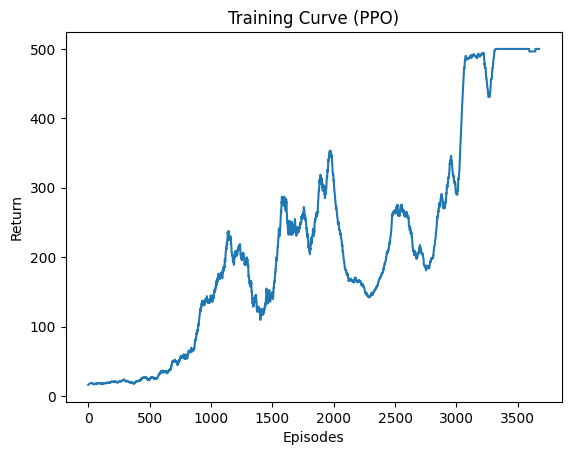

In [20]:
import numpy as np

def smooth(x, window=50):
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode="valid")

plt.plot(smooth(returns))
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Training Curve (PPO)")


## Hyperparameter tuning

We try some sets of hyperparameter configs mainly changing the learning rates (of both actors and critics), as well as the size of the neural network layers.

Running config: ActorLR=3.0e-04, CriticLR=3.0e-04, Hidden=(64, 64)
Update 49: Episodes=1575, MeanLast100=241.87, ActorLoss=0.039, CriticLoss=136.997, Entropy=0.579, Time for 50 updates=250.496s
Update 99: Episodes=2192, MeanLast100=233.05, ActorLoss=0.023, CriticLoss=31.391, Entropy=0.584, Time for 50 updates=243.074s
  Run 1: Final Mean Reward = 233.05
Running config: ActorLR=3.0e-04, CriticLR=3.0e-04, Hidden=(128, 64)
Update 49: Episodes=1831, MeanLast100=242.83, ActorLoss=0.018, CriticLoss=174.764, Entropy=0.586, Time for 50 updates=247.807s
Update 99: Episodes=2752, MeanLast100=211.25, ActorLoss=0.060, CriticLoss=23.136, Entropy=0.520, Time for 50 updates=244.330s
  Run 1: Final Mean Reward = 211.25
Running config: ActorLR=1.0e-03, CriticLR=3.0e-03, Hidden=(64, 64)
Update 49: Episodes=1318, MeanLast100=498.09, ActorLoss=0.017, CriticLoss=95.226, Entropy=0.470, Time for 50 updates=246.858s
Update 99: Episodes=1729, MeanLast100=497.82, ActorLoss=0.048, CriticLoss=27.353, Entropy=0.54

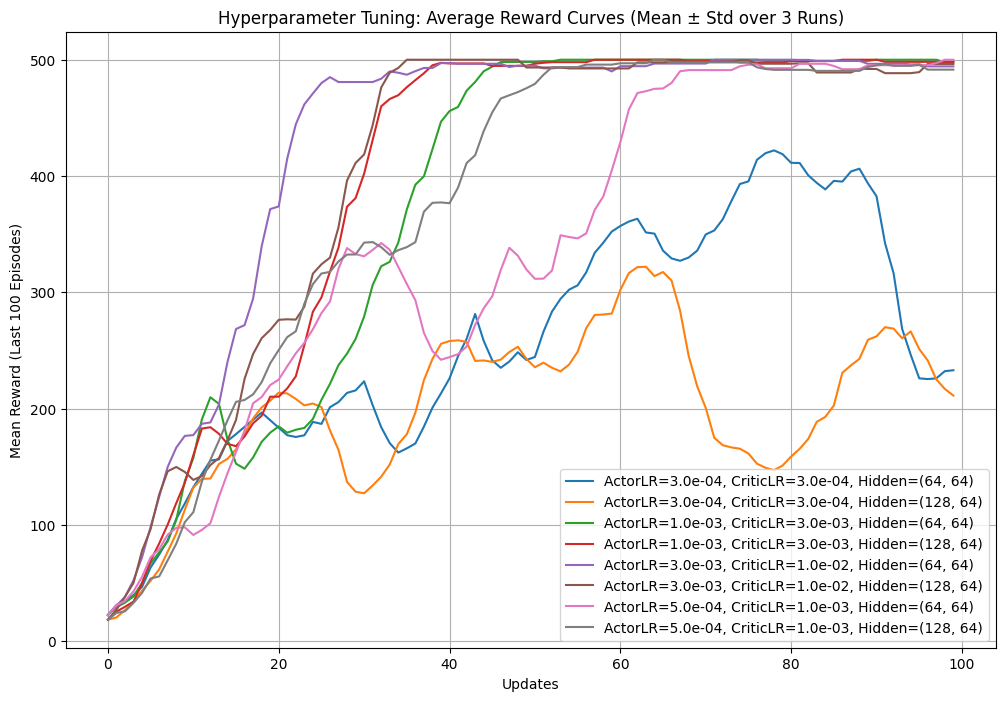


Hyperparameter Tuning Summary:
| Config Label                          | Avg Final Mean Reward | Std Final Mean Reward |
|---------------------------------------|-----------------------|-----------------------|
| ActorLR=3.0e-04, CriticLR=3.0e-04, Hidden=(64, 64) | 233.05                | 0.00                  |
| ActorLR=3.0e-04, CriticLR=3.0e-04, Hidden=(128, 64) | 211.25                | 0.00                  |
| ActorLR=1.0e-03, CriticLR=3.0e-03, Hidden=(64, 64) | 497.82                | 0.00                  |
| ActorLR=1.0e-03, CriticLR=3.0e-03, Hidden=(128, 64) | 498.18                | 0.00                  |
| ActorLR=3.0e-03, CriticLR=1.0e-02, Hidden=(64, 64) | 494.28                | 0.00                  |
| ActorLR=3.0e-03, CriticLR=1.0e-02, Hidden=(128, 64) | 496.38                | 0.00                  |
| ActorLR=5.0e-04, CriticLR=1.0e-03, Hidden=(64, 64) | 499.97                | 0.00                  |
| ActorLR=5.0e-04, CriticLR=1.0e-03, Hidden=(128, 64) | 491.48  

In [22]:
import time
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import gymnax
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Actor & Critic Networks (Parameterized by hidden_sizes)
# ---------------------------
class Actor(nn.Module):
    hidden_sizes: tuple
    action_dim: int

    @nn.compact
    def __call__(self, x):
        for size in self.hidden_sizes:
            x = nn.Dense(size)(x)
            x = nn.relu(x)
        return nn.Dense(self.action_dim)(x)  # logits

class Critic(nn.Module):
    hidden_sizes: tuple

    @nn.compact
    def __call__(self, x):
        for size in self.hidden_sizes:
            x = nn.Dense(size)(x)
            x = nn.relu(x)
        return nn.Dense(1)(x).squeeze(-1)  # scalar value

# ---------------------------
# Init models & opts
# ---------------------------
def init_models_and_opts(rng, obs_shape, action_dim, actor_hidden_sizes, critic_hidden_sizes, actor_lr, critic_lr):
    rng, a_key, c_key = jax.random.split(rng, 3)
    dummy_obs = jnp.zeros(obs_shape)

    actor = Actor(hidden_sizes=actor_hidden_sizes, action_dim=action_dim)
    critic = Critic(hidden_sizes=critic_hidden_sizes)

    params_actor = actor.init(a_key, dummy_obs)
    params_critic = critic.init(c_key, dummy_obs)

    opt_actor = optax.adam(actor_lr)
    opt_critic = optax.adam(critic_lr)

    opt_state_actor = opt_actor.init(params_actor)
    opt_state_critic = opt_critic.init(params_critic)

    return actor, critic, params_actor, params_critic, opt_actor, opt_critic, opt_state_actor, opt_state_critic

# ---------------------------
# Utilities
# ---------------------------
def categorical_logprob(logits, actions):
    logp_all = jax.nn.log_softmax(logits)
    return logp_all[jnp.arange(actions.shape[0]), actions]

def policy_entropy(logits):
    p = jax.nn.softmax(logits)
    return -jnp.sum(p * jax.nn.log_softmax(logits), axis=-1)

def compute_gae(rewards, values, dones, last_value, gamma=0.99, lambda_=0.95):
    T, N = rewards.shape
    advantages = jnp.zeros((T, N))
    gae = jnp.zeros(N)
    for t in range(T - 1, -1, -1):
        next_value = jnp.where(t == T - 1, last_value, values[t + 1])
        next_nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_value * next_nonterminal - values[t]
        gae = delta + gamma * lambda_ * next_nonterminal * gae
        advantages = advantages.at[t].set(gae)
    returns = advantages + values
    return advantages, returns

# ---------------------------
# PPO training function (Abstracted with more hyperparameters)
# ---------------------------
def train_ppo(rng,
              num_envs=16,
              T=128,
              total_updates=1000,
              ppo_epochs=4,
              minibatch_size=256,
              gamma=0.99,
              lambda_=0.95,
              clip_eps=0.2,
              value_coef=0.5,  # Note: Not used in current loss, but kept for potential extension
              entropy_coef=0.01,
              actor_hidden_sizes=(128, 64),
              critic_hidden_sizes=(128, 64),
              actor_lr=3e-4,
              critic_lr=3e-4,
              verbose_interval=10):

    env, env_params = gymnax.make("CartPole-v1")
    obs_shape = env.observation_space(env_params).shape
    action_dim = env.action_space(env_params).n

    # init nets and opts
    actor, critic, params_actor, params_critic, opt_actor, opt_critic, opt_state_actor, opt_state_critic = \
        init_models_and_opts(rng, obs_shape, action_dim, actor_hidden_sizes, critic_hidden_sizes, actor_lr, critic_lr)

    # reset vectorized envs
    rng, reset_key = jax.random.split(rng)
    reset_keys = jax.random.split(reset_key, num_envs)
    obs, env_states = jax.vmap(env.reset, in_axes=(0, None))(reset_keys, env_params)

    # batched actor/critic apply
    batched_actor_apply = jax.jit(jax.vmap(actor.apply, in_axes=(None, 0)))
    batched_critic_apply = jax.jit(jax.vmap(critic.apply, in_axes=(None, 0)))

    # jit action selection
    @jax.jit
    def select_actions_and_logp(params_actor, obs_batch, rng):
        logits = batched_actor_apply(params_actor, obs_batch)
        rng, subkey = jax.random.split(rng)
        keys = jax.random.split(subkey, obs_batch.shape[0])
        actions = jax.vmap(lambda k, l: jax.random.categorical(k, l))(keys, logits)
        logp = categorical_logprob(logits, actions)
        ent = policy_entropy(logits)
        return actions, logp, ent.mean(), logits, rng  # Mean entropy for logging

    # jit env.step
    @jax.jit
    def step_jit(rng, env_state, action):
        next_obs, next_env_state, reward, done, info = env.step(rng, env_state, action, env_params)
        return next_obs, next_env_state, reward, done, info

    vectorized_step = jax.vmap(step_jit, in_axes=(0, 0, 0))

    # PPO minibatch update
    def ppo_update(params_actor, params_critic, opt_state_actor, opt_state_critic,
                   obs_mb, acts_mb, old_logp_mb, adv_mb, returns_mb, clip_eps):

        def loss_fn_actor(p):
            logits = batched_actor_apply(p, obs_mb)
            logp = categorical_logprob(logits, acts_mb)
            ratio = jnp.exp(logp - old_logp_mb)
            unclipped = ratio * adv_mb
            clipped = jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_mb
            actor_loss = -jnp.mean(jnp.minimum(unclipped, clipped))
            entropy = jnp.mean(policy_entropy(logits))
            return actor_loss - entropy_coef * entropy, (actor_loss, entropy)

        (actor_loss_total, (actor_loss_term, entropy_term)), actor_grads = jax.value_and_grad(loss_fn_actor, has_aux=True)(params_actor)
        updates_actor, opt_state_actor = opt_actor.update(actor_grads, opt_state_actor)
        params_actor = optax.apply_updates(params_actor, updates_actor)

        def loss_fn_critic(p):
            value_pred = batched_critic_apply(p, obs_mb)
            value_loss = jnp.mean((returns_mb - value_pred) ** 2)
            return value_loss, value_loss

        (critic_loss_val, critic_loss_term), critic_grads = jax.value_and_grad(loss_fn_critic, has_aux=True)(params_critic)
        updates_critic, opt_state_critic = opt_critic.update(critic_grads, opt_state_critic)
        params_critic = optax.apply_updates(params_critic, updates_critic)

        return params_actor, params_critic, opt_state_actor, opt_state_critic, actor_loss_term, critic_loss_term, entropy_term

    ppo_update = jax.jit(ppo_update)

    episodic_returns = []
    env_running_reward = jnp.zeros(num_envs)
    update_time = []
    mean_rewards_per_update = []  # Track mean of last 100 episodes per update

    for update_i in range(total_updates):
        start_time = time.time()
        obs_buf, actions_buf, logp_buf, rewards_buf, dones_buf, values_buf, logits_buf = [], [], [], [], [], [], []

        for t in range(T):
            values = batched_critic_apply(params_critic, obs)
            actions, logp, ent, logits, rng = select_actions_and_logp(params_actor, obs, rng)

            rng, step_rng = jax.random.split(rng)
            step_keys = jax.random.split(step_rng, num_envs)
            next_obs, env_states, rews, dones, infos = vectorized_step(step_keys, env_states, actions)

            obs_buf.append(obs)
            actions_buf.append(actions)
            logp_buf.append(logp)
            rewards_buf.append(rews)
            dones_buf.append(dones)
            values_buf.append(values)
            logits_buf.append(logits)

            env_running_reward += rews
            for i in range(num_envs):
                if dones[i]:
                    episodic_returns.append(float(env_running_reward[i]))
                    env_running_reward = env_running_reward.at[i].set(0.0)

            obs = next_obs

        # convert to arrays
        obs_arr = jnp.stack(obs_buf)
        acts_arr = jnp.stack(actions_buf)
        logp_arr = jnp.stack(logp_buf)
        rews_arr = jnp.stack(rewards_buf)
        dones_arr = jnp.stack(dones_buf)
        vals_arr = jnp.stack(values_buf)

        last_values = batched_critic_apply(params_critic, obs)
        advantages, returns = compute_gae(rews_arr, vals_arr, dones_arr, last_values, gamma, lambda_)

        # flatten
        T_, N = advantages.shape
        batch_size = T_ * N
        obs_flat = obs_arr.reshape((batch_size,) + obs_arr.shape[2:])
        acts_flat = acts_arr.reshape((batch_size,))
        logp_flat = logp_arr.reshape((batch_size,))
        adv_flat = advantages.reshape((batch_size,))
        returns_flat = returns.reshape((batch_size,))

        adv_flat = (adv_flat - jnp.mean(adv_flat)) / (jnp.std(adv_flat) + 1e-8)

        perm_key, rng = jax.random.split(rng)
        perm = jax.random.permutation(perm_key, batch_size)

        for epoch in range(ppo_epochs):
            perm_key, rng = jax.random.split(rng)
            perm = jax.random.permutation(perm_key, batch_size)
            for start in range(0, batch_size, minibatch_size):
                end = start + minibatch_size
                mb_idx = perm[start:end]
                mb_obs = obs_flat[mb_idx]
                mb_acts = acts_flat[mb_idx]
                mb_old_logp = logp_flat[mb_idx]
                mb_adv = adv_flat[mb_idx]
                mb_returns = returns_flat[mb_idx]

                params_actor, params_critic, opt_state_actor, opt_state_critic, actor_loss, critic_loss, entropy = \
                    ppo_update(params_actor, params_critic, opt_state_actor, opt_state_critic,
                               mb_obs, mb_acts, mb_old_logp, mb_adv, mb_returns, clip_eps)

        update_time.append(time.time() - start_time)

        # Compute mean of last 100 episodes for tracking
        last_100 = episodic_returns[-100:]
        mean_last_100 = (sum(last_100) / len(last_100)) if len(last_100) > 0 else 0.0
        mean_rewards_per_update.append(mean_last_100)

        if (update_i+1) % verbose_interval == 0:
            time_to_update = sum(update_time[-verbose_interval:]) if len(update_time) >= verbose_interval else sum(update_time)
            print(f"Update {update_i}: Episodes={len(episodic_returns)}, MeanLast100={mean_last_100:.2f}, "
                  f"ActorLoss={actor_loss:.3f}, CriticLoss={critic_loss:.3f}, Entropy={float(entropy):.3f}, "
                  f"Time for {verbose_interval} updates={time_to_update:.3f}s")

    return mean_rewards_per_update, episodic_returns

# ---------------------------
# Hyperparameter Tuning Script
# ---------------------------
def run_hyperparameter_tuning():
    # Define up to 8 hyperparameter sets (combinations of LR and network complexity)
    # Here: 4 LR pairs x 2 network sizes = 8 sets
    lr_pairs = [
        (3e-4, 3e-4),    # Low LR
        (1e-3, 3e-3),    # Medium LR
        (3e-3, 1e-2),    # High LR
        (5e-4, 1e-3)     # Mixed LR
    ]
    hidden_sizes_options = [
        (64, 64),        # Smaller network
        (128, 64)        # Larger network (original)
    ]
    configs = []
    for lr_pair in lr_pairs:
        for hidden in hidden_sizes_options:
            configs.append({
                "actor_lr": lr_pair[0],
                "critic_lr": lr_pair[1],
                "actor_hidden_sizes": hidden,
                "critic_hidden_sizes": hidden,  # Same for actor and critic
                "label": f"ActorLR={lr_pair[0]:.1e}, CriticLR={lr_pair[1]:.1e}, Hidden={hidden}"
            })

    num_runs_per_config = 1
    total_updates = 100
    results = {}  # config_label: {"mean_curves": list of arrays (runs), "final_means": list of floats (runs), "avg_final": float, "std_final": float}

    for config in configs:
        print(f"Running config: {config['label']}")
        mean_curves = []
        final_means = []
        for run_i in range(num_runs_per_config):
            seed = 42 + run_i  # Different seeds for each run
            rng = jax.random.PRNGKey(seed)
            mean_rewards, _ = train_ppo(
                rng,
                num_envs=32,
                T=128,
                total_updates=total_updates,
                ppo_epochs=4,
                minibatch_size=1024,
                actor_hidden_sizes=config["actor_hidden_sizes"],
                critic_hidden_sizes=config["critic_hidden_sizes"],
                actor_lr=config["actor_lr"],
                critic_lr=config["critic_lr"],
                verbose_interval=50  # Less verbose for tuning
            )
            mean_curves.append(np.array(mean_rewards))
            final_mean = mean_rewards[-1] if len(mean_rewards) > 0 else 0.0
            final_means.append(final_mean)
            print(f"  Run {run_i+1}: Final Mean Reward = {final_mean:.2f}")

        avg_curve = np.mean(mean_curves, axis=0)
        results[config['label']] = {
            "mean_curves": mean_curves,
            "final_means": final_means,
            "avg_final": np.mean(final_means),
            "std_final": np.std(final_means)
        }

    # Plot average reward curves for each config
    plt.figure(figsize=(12, 8))
    updates = np.arange(total_updates)
    for label, res in results.items():
        avg_curve = np.mean(res["mean_curves"], axis=0)
        std_curve = np.std(res["mean_curves"], axis=0)
        plt.plot(updates, avg_curve, label=label)
        plt.fill_between(updates, avg_curve - std_curve, avg_curve + std_curve, alpha=0.2)
    plt.xlabel("Updates")
    plt.ylabel("Mean Reward (Last 100 Episodes)")
    plt.title("Hyperparameter Tuning: Average Reward Curves (Mean ± Std over 3 Runs)")
    plt.legend()
    plt.grid(True)
    plt.savefig("tuning_curves.png")
    plt.show()

    # Report summary table (industry standard: config, avg final reward, std)
    print("\nHyperparameter Tuning Summary:")
    print("| Config Label                          | Avg Final Mean Reward | Std Final Mean Reward |")
    print("|---------------------------------------|-----------------------|-----------------------|")
    for label, res in results.items():
        print(f"| {label:<37} | {res['avg_final']:<21.2f} | {res['std_final']:<21.2f} |")

if __name__ == "__main__":
    run_hyperparameter_tuning()

We can see that the better performing hyperparams managed to solve the cartpole problem in about 30 updates, in particular the purple curve. 30 updates is about 150 seconds or less than 3 minutes, which is a lot faster than the other methods we have tried. There are many other hyperparams that we can change (such as increasing the num_envs and rollout size) to possibly further improve the learning curve